In [1]:
using Flux
using Statistics
using Plots
using Zygote
using Random
using JLD2

In [2]:
const L = 10.0f0
const t_end = 5.0f0
const ν = 0.1f0

const u_mean = 1.0f0
const u_amplitude = 0.5f0
const k = 2.0f0*pi/L
u0(x) = Float32(u_mean + u_amplitude * cos(k*x))

nx_vis, nt_vis = 100, 100
x_grid = range(0f0, L; length=nx_vis) |> collect
t_grid = range(0f0, t_end; length=nt_vis) |> collect

const λ_pde = 3.0f0
const λ_ic = 1.0f0
const λ_bc = 1.0f0;

In [3]:
rng = Random.default_rng()

rand_x(rng, N) = rand(rng, Float32, N) .* L
rand_t(rng, N) = rand(rng, Float32, N) .* t_end
rand_f(rng, N) = [(x, t) for (x, t) in zip(rand_x(rng, N), rand_t(rng, N))]

rand_t_bc(rng, N) = rand(rng, Float32, N) .* t_end
rand_x_ic(rng, N) = rand(rng, Float32, N) .* L;

In [4]:
NN = Chain(
    Dense(2, 64, tanh),
    Dense(64, 64, tanh),
    Dense(64, 2)
) |> f32;

In [5]:
# Scalar output wrapper
function û(m, x::Float32, t::Float32)
    out = m([x, t])
    return out[1], out[2]  # (u, v)
end

dudt(m, x, t) = Zygote.gradient(tt -> first(û(m, x, tt)), t)[1]
dudx(m, x, t) = Zygote.gradient(xx -> first(û(m, xx, t)), x)[1]
dvdx(m, x, t)  = Zygote.gradient(xx -> last(û(m, xx, t)), x)[1]

# PDE Residual
residuals(m, x::Float32, t::Float32) = begin
    u, v = û(m, x, t)
    ut = dudt(m, x, t)
    ux = dudx(m, x, t)
    vx = dvdx(m, x, t)
    
    r1 = ut + u*v - ν*vx # PDE in First order form
    r2 = v - ux # Definition of v 
    return r1, r2
end;

In [6]:
function loss_pde(m, pde_xts)
    res = (residuals(m, x, t) for (x, t) in pde_xts)
    mean(r1^2 + r2^2 for (r1, r2) in res)
end
function loss_bc(m, bc_ts, L)
    mean((abs2(first(û(m, 0.0f0, t)) - first(û(m, L, t)))) for t in bc_ts)
end
function loss_ic(m, ic_xs, u0)
    mean((abs2(first(û(m, x, 0.0f0)) - u0(x))) for x in ic_xs)
end

function total_loss(m, pde_xts, bc_ts, ic_xs, L, u0)
   return λ_bc*loss_bc(m, bc_ts, L) + λ_ic*loss_ic(m, ic_xs, u0) + λ_pde*loss_pde(m, pde_xts)
end;

In [7]:
# Optimiser + state
opt = Flux.Optimisers.Adam(0.005)
state = Flux.setup(opt, NN);

In [ ]:
N_f = 128
N_ic = 10
N_bc = 10
epochs = 2000

# Training loop
losses = []

for epoch in 1:epochs
    pde_xts = rand_f(rng, N_f)
    bc_ts = rand_t_bc(rng, N_bc)
    ic_xs = rand_x_ic(rng, N_ic)
    
    loss, grad = Flux.withgradient(NN) do m
        total_loss(m, pde_xts, bc_ts, ic_xs, L, u0)
    end
    push!(losses, loss)
    Flux.update!(state, NN, grad[1])
    
    if epoch % 50 == 0
        println("Epoch=$epoch, loss=$(loss)")
    end
end

Epoch=50, loss=0.14592823


In [41]:
data=load("burgers1d_periodic.jld2")

t_grid = Float32.(data["times"])
x_grid = Float32.(collect(data["grid"]))
u_target = data["solution"];

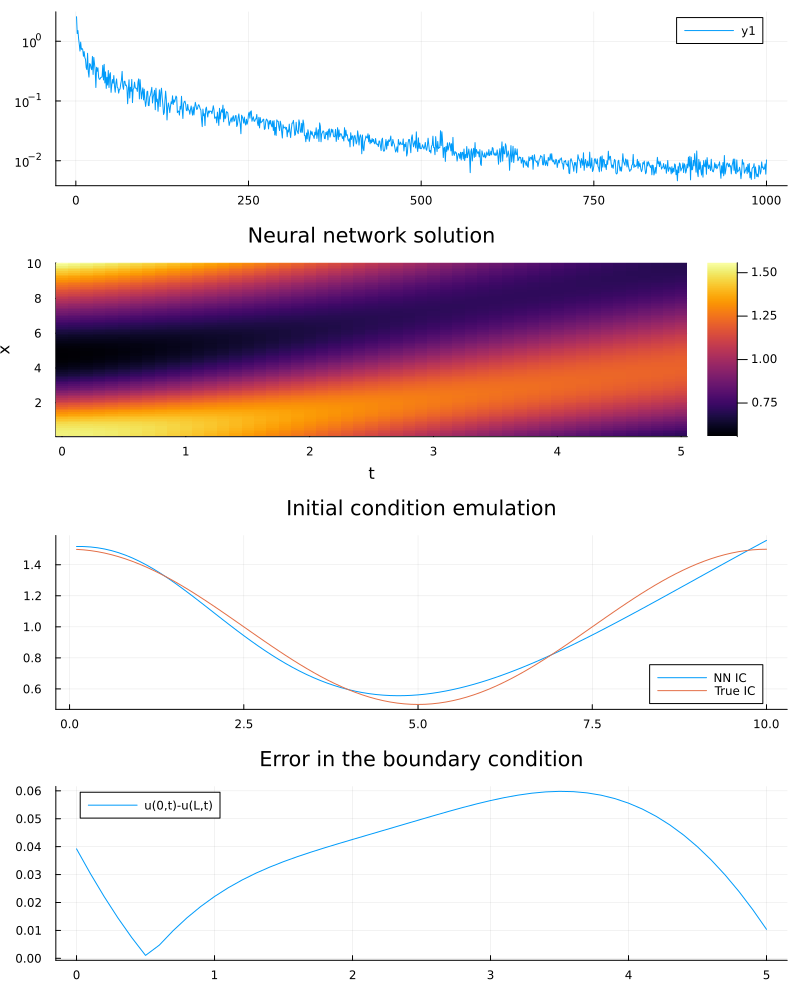

In [42]:
us = zeros((length(x_grid), length(t_grid)))
for i in 1:length(x_grid), j in 1:length(t_grid)
    x = x_grid[i]
    t = t_grid[j]
    us[i, j] = first(û(NN, x, t))
end

ic = us[:,1]
bc = abs.(us[1,:] .- us[end,:])

p0 = plot(losses, yscale=:log10)
p1 = heatmap(t_grid, x_grid, us, xlabel="t", ylabel='x', title="Neural network solution")
p2 = plot(x_grid, ic, label="NN IC")
plot!(p2, x_grid, u0.(x_grid), label="True IC", title="Initial condition emulation")
p3 = plot(t_grid, bc, label="u(0,t)-u(L,t)", title="Error in the boundary condition")
plot(p0, p1, p2, p3, layout=(4,1), size=(800,1000))

[ Info: Saved animation to /home/mlenes/Code/surrogate_flow/emulated_burgers.gif


Plots.AnimatedGif("/home/mlenes/Code/surrogate_flow/emulated_burgers.gif")
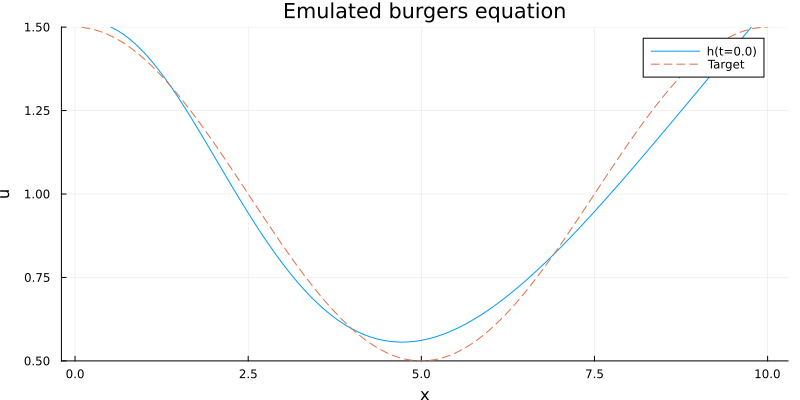

In [44]:
anim = @animate for i in 1:length(t_grid)
    p1 = plot(x_grid, us[:,i], label="h(t=$(round(t_grid[i],digits=2)))", xlabel='x', ylabel='u', ylim=(u_mean-u_amplitude, u_mean+u_amplitude))
    plot!(x_grid, u_target[i], label="Target", linestyle=:dash, legend=:topright)
    plot(p1, size=(800,400), title="Emulated burgers equation")
end
gif(anim, "emulated_burgers.gif", fps=15)